# Notebook 1: E-GMD Dataset Exploration & Subsetting Strategy

**Objective:** Explore the structure and metadata of the Expanded Groove MIDI Dataset (E-GMD) to understand its characteristics and devise a strategy for creating a manageable, representative subset for model development.

## 1. Setup and Imports

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import typing
import os
import shutil
from tqdm.notebook import tqdm
import librosa
import librosa.display
import pretty_midi
import random
from IPython.display import Audio, display

In [6]:
# Configure plots
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [7]:
# Define functions for Roland to simplified GM mapping conversion
def get_roland_to_simplified_category(pitch):
    """
    Convert Roland drum mapping to simplified drum categories.

    Args:
        pitch (int): MIDI pitch number in Roland mapping

    Returns:
        tuple: (new_pitch, category_name) with standardized pitch and category
    """
    # Define pitch mappings from Roland to simplified categories
    roland_to_simple = {
        # Kicks
        36: (36, "Kick"),

        # Snares
        38: (38, "Snare"),
        40: (38, "Snare"),  # Snare rim -> Snare
        37: (38, "Snare"),  # X-stick -> Snare

        # Toms
        48: (47, "Tom"),    # Tom 1 -> Tom
        50: (47, "Tom"),    # Tom 1 rim -> Tom
        45: (47, "Tom"),    # Tom 2 -> Tom
        47: (47, "Tom"),    # Tom 2 rim -> Tom
        43: (47, "Tom"),    # Tom 3 -> Tom
        58: (47, "Tom"),    # Tom 3 rim -> Tom

        # Hi-Hats
        46: (42, "HiHat"),  # HH Open -> HiHat
        26: (42, "HiHat"),  # HH Open Edge -> HiHat
        42: (42, "HiHat"),  # HH Closed -> HiHat
        22: (42, "HiHat"),  # HH Closed Edge -> HiHat
        44: (42, "HiHat"),  # HH Pedal -> HiHat

        # Crash Cymbals
        49: (49, "Crash"),  # Crash 1 -> Crash
        55: (49, "Crash"),  # Crash 1 Edge -> Crash
        57: (49, "Crash"),  # Crash 2 -> Crash
        52: (49, "Crash"),  # Crash 2 Edge -> Crash

        # Ride Cymbals
        51: (51, "Ride"),   # Ride -> Ride
        59: (51, "Ride"),   # Ride Edge -> Ride
        53: (51, "Ride")    # Ride Bell -> Ride
    }

    return roland_to_simple.get(pitch, (pitch, f"Unknown ({pitch})"))


def get_drum_name_simplified(pitch):
    """
    Get simplified drum name for visualization purposes.

    Args:
        pitch (int): MIDI pitch number

    Returns:
        str: Simplified drum name
    """
    _, category = get_roland_to_simplified_category(pitch)
    return category

In [8]:
def convert_midi_to_simplified_mapping(midi_path, output_path):
    """
    Converts a MIDI file from Roland drum mapping to simplified GM drum mapping.

    Args:
        midi_path: Path to the source MIDI file
        output_path: Path to save the converted MIDI file

    Returns:
        bool: True if conversion was successful, False otherwise
    """
    try:
        # Load the MIDI file
        pm = pretty_midi.PrettyMIDI(str(midi_path))

        # Process each instrument
        for instrument in pm.instruments:
            if instrument.is_drum:
                # Create a new list for converted notes
                new_notes = []

                # Process each note
                for note in instrument.notes:
                    # Get the new pitch using our mapping function
                    new_pitch, _ = get_roland_to_simplified_category(
                        note.pitch)

                    # Create a new note with the converted pitch
                    new_note = pretty_midi.Note(
                        velocity=note.velocity,
                        pitch=new_pitch,
                        start=note.start,
                        end=note.end
                    )
                    new_notes.append(new_note)

                # Replace the old notes with the new ones
                instrument.notes = new_notes

        # Save the modified MIDI file
        pm.write(str(output_path))
        return True

    except Exception as e:
        print(f"Error converting MIDI file: {e}")
        return False

## 2. Define Dataset Path

Specify the relative path to the root directory where the E-GMD dataset was extracted.

In [9]:
# Define the path relative to the notebooks directory
DATASET_PATH: Path = Path("../data/raw/e-gmd-v1.0.0/")

In [10]:
# Verify the path exists
if not DATASET_PATH.exists():
    print(f"Error: Dataset path not found at {DATASET_PATH.resolve()}")
else:
    print(f"Dataset path found: {DATASET_PATH.resolve()}")

Dataset path found: /home/ivan/uni/APPSA/DrumScribe-AI/data/raw/e-gmd-v1.0.0


## 3. Load Metadata

Load the main metadata file (`e-gmd-v1.0.0.csv`) into a pandas DataFrame.

In [11]:
METADATA_FILE: Path = DATASET_PATH / "e-gmd-v1.0.0.csv"

In [12]:
if not METADATA_FILE.exists():
    print(f"Error: Metadata file not found at {METADATA_FILE.resolve()}")
else:
    print(f"Loading metadata from: {METADATA_FILE.resolve()}")
    try:
        metadata_df: pd.DataFrame = pd.read_csv(METADATA_FILE)
        print("Metadata loaded successfully.")
    except Exception as e:
        print(f"Error loading metadata: {e}")
        metadata_df = pd.DataFrame()

Loading metadata from: /home/ivan/uni/APPSA/DrumScribe-AI/data/raw/e-gmd-v1.0.0/e-gmd-v1.0.0.csv
Metadata loaded successfully.


## 4. Explore Metadata

Perform initial exploration of the metadata to understand the available fields, data types, and distributions.

### 4.1. Basic Information

In [13]:
if not metadata_df.empty:
    print("First 5 rows:")
    display(metadata_df.head())
    print("\nDataFrame Info:")
    metadata_df.info()
else:
    print("Metadata DataFrame is empty, skipping exploration.")

First 5 rows:


,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Acoustic Kit
1,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,JingleStacks (2nd Hi-Hat)
2,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Studio (Live Room)
3,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Classic Rock
4,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Jazz Funk



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45537 entries, 0 to 45536
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   drummer         45537 non-null  object 
 1   session         45537 non-null  object 
 2   id              45537 non-null  object 
 3   style           45537 non-null  object 
 4   bpm             45537 non-null  int64  
 5   beat_type       45537 non-null  object 
 6   time_signature  45537 non-null  object 
 7   duration        45537 non-null  float64
 8   split           45537 non-null  object 
 9   midi_filename   45537 non-null  object 
 10  audio_filename  45537 non-null  object 
 11  kit_name        45537 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 4.2+ MB


### 4.2. Descriptive Statistics (Numerical Columns)

In [14]:
if not metadata_df.empty:
    print("Descriptive Statistics:")
    display(metadata_df.describe())
else:
    print("Metadata DataFrame is empty, skipping statistics.")

Descriptive Statistics:


,bpm,duration
count,45537.000000,45537.000000
mean,109.805477,35.140608
std,23.992195,66.746390
min,50.000000,0.669841
25%,95.000000,2.068957
50%,110.000000,3.502789
75%,125.000000,36.179592
max,290.000000,611.754989


### 4.3. Value Counts (Categorical Columns)

Examine the distribution of key categorical features like `drummer`, `session`, `style`, and `time_signature`.

In [15]:
if not metadata_df.empty:
    categorical_cols: typing.List[str] = [
        "drummer",
        "session",
        "style",
        "time_signature",
        "split",
    ]
    for col in categorical_cols:
        if col in metadata_df.columns:
            print(f"\n--- Value Counts for '{col}' ---")
            print(metadata_df[col].value_counts())
        else:
            print(f"\nColumn '{col}' not found in metadata.")
else:
    print("Metadata DataFrame is empty, skipping value counts.")


--- Value Counts for 'drummer' ---
drummer
drummer1     20726
drummer7     14018
drummer3      4171
drummer5      2322
drummer8      1591
drummer9      1290
drummer6       645
drummer10      387
drummer4       387
Name: count, dtype: int64

--- Value Counts for 'session' ---
session
drummer1/session1        11352
drummer1/session2         8213
drummer7/session3         6364
drummer7/session2         5633
drummer3/session1         2150
drummer3/session2         2021
drummer7/session1         1591
drummer9/session1         1290
drummer8/session1         1161
drummer5/session2         1032
drummer5/session1          860
drummer1/session3          731
drummer1/eval_session      430
drummer8/eval_session      430
drummer7/eval_session      430
drummer5/eval_session      430
drummer10/session1         387
drummer4/session1          387
drummer6/session3          301
drummer6/session1          215
drummer6/session2          129
Name: count, dtype: int64

--- Value Counts for 'style' ---
styl

### 4.4. Distribution Visualization (Numerical Columns)

Visualize the distribution of numerical columns like `tempo`.

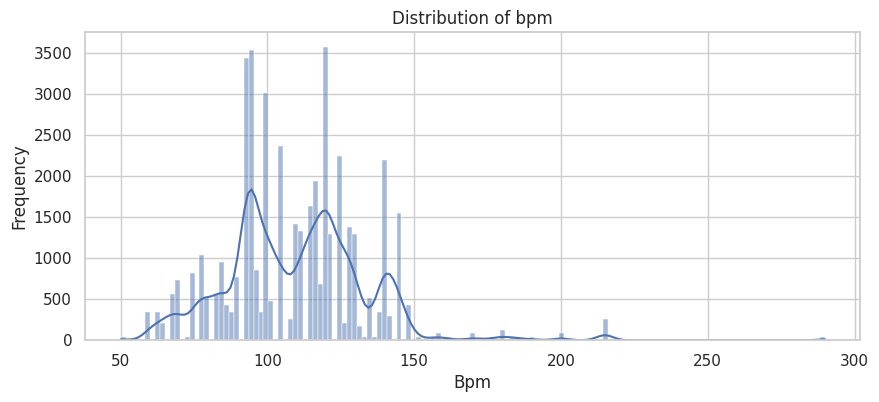

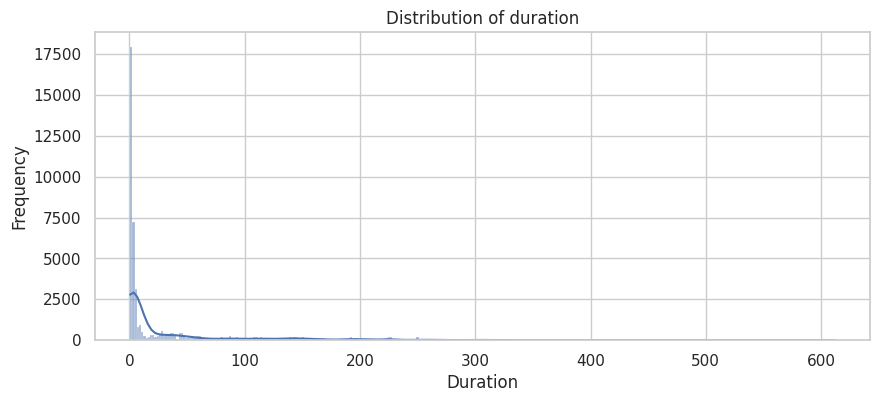

In [16]:
if not metadata_df.empty:
    numerical_cols: typing.List[str] = ["bpm", "duration"]
    for col in numerical_cols:
        if col in metadata_df.columns:
            plt.figure(figsize=(10, 4))
            sns.histplot(metadata_df[col], kde=True)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col.capitalize())
            plt.ylabel("Frequency")
            plt.show()
        else:
            print(f"\nColumn '{col}' not found for visualization.")
else:
    print("Metadata DataFrame is empty, skipping visualizations.")

## 5. Implement Subset Extraction Pipeline

Since the dataset is huge (+100 GB), we are going to reduce it.

To do so we will use the `drummer` column since to make a subset that is representative of the entire dataset. The `drummer` column contains 9 unique drummers, and we will create a stratified sample of 10% of the dataset based on this column.

We will then copy the corresponding audio and MIDI files to a new directory and save the subset's metadata.

In [17]:
# Ensure metadata_df is loaded and not empty before proceeding
if "metadata_df" in locals() and not metadata_df.empty:
    print("Performing stratified sampling based on 'drummer'...")
    # Group by drummer and sample 10% from each group
    df_subset = metadata_df.groupby("drummer", group_keys=False).sample(
        frac=0.1, random_state=42
    )

    print("\nSubset created. First 5 rows:")
    display(df_subset.head())

    print(f"\nShape of the subset DataFrame: {df_subset.shape}")
else:
    print("Metadata DataFrame not loaded or empty. Skipping subset creation.")
    df_subset = pd.DataFrame()  # Assign empty df if metadata wasn't loaded

Performing stratified sampling based on 'drummer'...

Subset created. First 5 rows:


,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name
20236,drummer1,drummer1/session2,drummer1/session2/80,punk,144,fill,4-4,1.661678,train,drummer1/session2/80_punk_144_fill_4-4_37.midi,drummer1/session2/80_punk_144_fill_4-4_37.wav,Live Fusion
10135,drummer1,drummer1/session1,drummer1/session1/224,rock/halftime,140,fill,4-4,1.714286,train,drummer1/session1/224_rock-halftime_140_fill_4...,drummer1/session1/224_rock-halftime_140_fill_4...,Funk Rock
42297,drummer1,drummer1/session2,drummer1/session2/149,gospel,120,fill,4-4,1.853129,validation,drummer1/session2/149_gospel_120_fill_4-4_41.midi,drummer1/session2/149_gospel_120_fill_4-4_41.wav,Cassette (Lo-Fi Compress)
11515,drummer1,drummer1/session1,drummer1/session1/260,funk/purdieshuffle,130,fill,4-4,1.846145,train,drummer1/session1/260_funk-purdieshuffle_130_f...,drummer1/session1/260_funk-purdieshuffle_130_f...,909 Simple
42499,drummer1,drummer1/session2,drummer1/session2/198,rock,115,fill,4-4,1.726984,validation,drummer1/session2/198_rock_115_fill_4-4_24.midi,drummer1/session2/198_rock_115_fill_4-4_24.wav,Heavy Metal



Shape of the subset DataFrame: (4554, 12)


In [18]:
# Verify stratification by comparing drummer distributions
if not df_subset.empty:
    print("Comparing drummer distribution (Original vs Subset):\n")

    original_counts = metadata_df["drummer"].value_counts(
        normalize=True).sort_index()
    subset_counts = df_subset["drummer"].value_counts(
        normalize=True).sort_index()

    comparison_df = pd.DataFrame(
        {"Original (%)": original_counts * 100,
         "Subset (%)": subset_counts * 100}
    )
    comparison_df["Difference (%)"] = (
        comparison_df["Subset (%)"] - comparison_df["Original (%)"]
    )

    display(comparison_df.style.format("{:.2f}%"))

    # Check if proportions are roughly similar (allowing for sampling variance)
    # Allow up to 5% difference
    if comparison_df["Difference (%)"].abs().max() < 5:
        print("\nStratification appears successful (proportions are similar).")
    else:
        print(
            "\nWarning: Stratification proportions differ significantly. Check sampling."
        )

else:
    print("Subset DataFrame is empty. Skipping stratification verification.")

Comparing drummer distribution (Original vs Subset):



,Original (%),Subset (%),Difference (%)
drummer,,,
drummer1,45.51%,45.52%,0.01%
drummer10,0.85%,0.86%,0.01%
drummer3,9.16%,9.16%,-0.00%
drummer4,0.85%,0.86%,0.01%
drummer5,5.10%,5.09%,-0.00%
drummer6,1.42%,1.41%,-0.01%
drummer7,30.78%,30.79%,0.00%
drummer8,3.49%,3.49%,-0.00%
drummer9,2.83%,2.83%,-0.00%



Stratification appears successful (proportions are similar).


### 5.1. Create Subset Directory and Copy Files

Define the path for the subset data and create the necessary directory structure. Then, iterate through the subset metadata, copying the corresponding audio (`.wav`) and MIDI (`.midi`) files from the original dataset path to the new subset path, maintaining the `split/drummer/session/style` structure. We use `shutil.copy2` to preserve metadata and `tqdm` for progress tracking.

In [19]:
# Define paths
SUBSET_PATH = Path("../data/subset/")
DATASET_PATH = Path("../data/raw/e-gmd-v1.0.0/")

if not df_subset.empty:
    print(f"Creating subset directory at: {SUBSET_PATH.resolve()}")
    os.makedirs(SUBSET_PATH, exist_ok=True)

    # Auto-detect dataset structure from first sample
    structure_pattern = None
    sample_row = df_subset.iloc[0]
    audio_filename = sample_row["audio_filename"]
    just_filename = os.path.basename(audio_filename)

    # Try common file patterns in order of likelihood
    patterns = [
        ("split/full_path", DATASET_PATH / sample_row["split"] / audio_filename),
        ("direct_path", DATASET_PATH / audio_filename),
        ("split/filename", DATASET_PATH / sample_row["split"] / just_filename),
        ("drummer/filename", DATASET_PATH / sample_row["drummer"] / just_filename)
    ]

    for name, path in patterns:
        if path.exists():
            structure_pattern = name
            print(f"Found dataset structure: {name}")
            break

    # Fallback to recursive search if needed
    if not structure_pattern:
        matches = list(DATASET_PATH.glob(f"**/{just_filename}"))
        if matches:
            structure_pattern = "recursive_search"
            print(f"Found files using recursive search")
        else:
            print("ERROR: Could not find files in dataset directory")

    # Function to locate files based on detected structure
    def find_file(row, field):
        filename = row[field]
        basename = os.path.basename(filename)

        paths = {
            "split/full_path": DATASET_PATH / row["split"] / filename,
            "direct_path": DATASET_PATH / filename,
            "split/filename": DATASET_PATH / row["split"] / basename,
            "drummer/filename": DATASET_PATH / row["drummer"] / basename
        }

        if structure_pattern in paths:
            return paths[structure_pattern]
        elif structure_pattern == "recursive_search":
            matches = list(DATASET_PATH.glob(f"**/{basename}"))
            return matches[0] if matches else None
        return DATASET_PATH / row["split"] / filename  # fallback

    # Copy files
    copied, skipped = 0, 0
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Copying files"):
        # Find source files
        src_audio = find_file(row, "audio_filename")
        src_midi = find_file(row, "midi_filename")

        # Setup target paths
        tgt_audio = SUBSET_PATH / row["split"] / row["audio_filename"]
        tgt_midi = SUBSET_PATH / row["split"] / row["midi_filename"]

        # Create directories
        os.makedirs(tgt_audio.parent, exist_ok=True)
        os.makedirs(tgt_midi.parent, exist_ok=True)

        # Copy and convert files
        success = True
        try:
            # Handle audio file
            if src_audio and src_audio.exists():
                shutil.copy2(src_audio, tgt_audio)
            else:
                success = False

            # Handle MIDI file
            if src_midi and src_midi.exists():
                if not convert_midi_to_simplified_mapping(src_midi, tgt_midi):
                    shutil.copy2(src_midi, tgt_midi)  # Fallback to direct copy
            else:
                success = False
        except Exception:
            success = False

        # Count results
        if success:
            copied += 1
        else:
            skipped += 1

    # Report results
    print(f"\nCopied {copied} file pairs, skipped {skipped} pairs")

    # Verify files
    audio_count = len(list(SUBSET_PATH.glob("**/*.wav")))
    midi_count = len(list(SUBSET_PATH.glob("**/*.mid*")))
    print(f"Found {audio_count} audio files and {midi_count} MIDI files in subset directory")

    if audio_count == 0 and midi_count == 0:
        print("WARNING: No files were copied! Check dataset paths.")
else:
    print("Subset DataFrame is empty. Skipping file copying.")

Creating subset directory at: /home/ivan/uni/APPSA/DrumScribe-AI/data/subset
Found dataset structure: direct_path


Copying files:   0%|          | 0/4554 [00:00<?, ?it/s]


Copied 4554 file pairs, skipped 0 pairs
Found 4554 audio files and 4554 MIDI files in subset directory


### 5.2. Save Subset Metadata

Finally, save the `df_subset` DataFrame containing the metadata for the newly created subset to a CSV file within the subset directory.

In [20]:
if not df_subset.empty:
    subset_metadata_path: Path = SUBSET_PATH / "subset_metadata.csv"
    print(f"Saving subset metadata to: {subset_metadata_path.resolve()}")
    try:
        df_subset.to_csv(subset_metadata_path, index=False)
        print("Subset metadata saved successfully.")
    except Exception as e:
        print(f"Error saving subset metadata: {e}")
else:
    print("Subset DataFrame is empty. Skipping metadata saving.")

Saving subset metadata to: /home/ivan/uni/APPSA/DrumScribe-AI/data/subset/subset_metadata.csv
Subset metadata saved successfully.


## 6. Create Train/Validation/Test Splits

Now that we have the subset metadata, we'll split it into training (70%), validation (15%), and test (15%) sets. We will stratify the split based on the `drummer` column to ensure each drummer is proportionally represented in all sets.

### 6.1. Load Subset Metadata

First, let's load the subset metadata file we created in the previous step in case we are resuming.

In [21]:
import pandas as pd
from pathlib import Path
import typing

# Define path to subset metadata
SUBSET_METADATA_PATH: Path = Path("../data/subset/subset_metadata.csv")

# Load the dataframe
if SUBSET_METADATA_PATH.exists():
    print(f"Loading subset metadata from: {SUBSET_METADATA_PATH.resolve()}")
    try:
        df_subset: pd.DataFrame = pd.read_csv(SUBSET_METADATA_PATH)
        print("Subset metadata loaded successfully.")
        display(df_subset.head())
    except Exception as e:
        print(f"Error loading subset metadata: {e}")
        df_subset = pd.DataFrame()  # Assign empty df on error
else:
    print(f"Error: Subset metadata file not found at {SUBSET_METADATA_PATH.resolve()}")
    df_subset = pd.DataFrame()

Loading subset metadata from: /home/ivan/uni/APPSA/DrumScribe-AI/data/subset/subset_metadata.csv
Subset metadata loaded successfully.


,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name
0,drummer1,drummer1/session2,drummer1/session2/80,punk,144,fill,4-4,1.661678,train,drummer1/session2/80_punk_144_fill_4-4_37.midi,drummer1/session2/80_punk_144_fill_4-4_37.wav,Live Fusion
1,drummer1,drummer1/session1,drummer1/session1/224,rock/halftime,140,fill,4-4,1.714286,train,drummer1/session1/224_rock-halftime_140_fill_4...,drummer1/session1/224_rock-halftime_140_fill_4...,Funk Rock
2,drummer1,drummer1/session2,drummer1/session2/149,gospel,120,fill,4-4,1.853129,validation,drummer1/session2/149_gospel_120_fill_4-4_41.midi,drummer1/session2/149_gospel_120_fill_4-4_41.wav,Cassette (Lo-Fi Compress)
3,drummer1,drummer1/session1,drummer1/session1/260,funk/purdieshuffle,130,fill,4-4,1.846145,train,drummer1/session1/260_funk-purdieshuffle_130_f...,drummer1/session1/260_funk-purdieshuffle_130_f...,909 Simple
4,drummer1,drummer1/session2,drummer1/session2/198,rock,115,fill,4-4,1.726984,validation,drummer1/session2/198_rock_115_fill_4-4_24.midi,drummer1/session2/198_rock_115_fill_4-4_24.wav,Heavy Metal


### 6.2. Perform Stratified Split

We'll use `sklearn.model_selection.train_test_split` twice to achieve the 70/15/15 split, stratified by `drummer`.

In [22]:
from sklearn.model_selection import train_test_split

RANDOM_STATE: int = 42
TRAIN_SIZE: float = 0.70  # 70% for training
VAL_TEST_SIZE: float = 0.30  # Remaining 30% for validation + test
VAL_SIZE_REL_TEMP: float = (
    0.50  # 50% of the temp set for validation (0.30 * 0.50 = 0.15 of total)
)
TEST_SIZE_REL_TEMP: float = (
    0.50  # 50% of the temp set for test (0.30 * 0.50 = 0.15 of total)
)

if not df_subset.empty:
    print("Performing train/validation/test split...")

    # Ensure the index is unique if it's not already (needed for mapping back)
    if not df_subset.index.is_unique:
        df_subset = df_subset.reset_index(drop=True)

    # Features (X) and target/stratification column (y)
    X = df_subset.index  # Use index to easily map back
    y = df_subset["drummer"]

    # First split: Train (70%) and Temp (30%)
    X_train_idx, X_temp_idx, y_train, y_temp = train_test_split(
        X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE, stratify=y, shuffle=True
    )

    # Second split: Validation (15%) and Test (15%) from Temp (30%)
    y_temp_stratify = df_subset.loc[X_temp_idx, "drummer"]
    X_val_idx, X_test_idx, y_val, y_test = train_test_split(
        X_temp_idx,
        y_temp_stratify,
        train_size=VAL_SIZE_REL_TEMP,
        random_state=RANDOM_STATE,
        stratify=y_temp_stratify,
        shuffle=True,
    )

    print("Splitting complete.")
    print(f"Train set size: {len(X_train_idx)}")
    print(f"Validation set size: {len(X_val_idx)}")
    print(f"Test set size: {len(X_test_idx)}")

else:
    print("Subset DataFrame is empty. Skipping split.")

Performing train/validation/test split...
Splitting complete.
Train set size: 3187
Validation set size: 683
Test set size: 684


### 6.3. Add 'split' Column to DataFrame

Now, add a column to the original `df_subset` indicating which split each row belongs to.

In [23]:
if not df_subset.empty and "X_train_idx" in locals():
    # Add the 'split' column
    df_subset["split_set"] = "unknown"  # Initialize column
    df_subset.loc[X_train_idx, "split_set"] = "train"
    df_subset.loc[X_val_idx, "split_set"] = "validation"
    df_subset.loc[X_test_idx, "split_set"] = "test"

    print("Added 'split_set' column to the DataFrame.")
    display(df_subset.head())
else:
    print(
        "Split indices not available or DataFrame empty. Skipping adding 'split_set' column."
    )

Added 'split_set' column to the DataFrame.


,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name,split_set
0,drummer1,drummer1/session2,drummer1/session2/80,punk,144,fill,4-4,1.661678,train,drummer1/session2/80_punk_144_fill_4-4_37.midi,drummer1/session2/80_punk_144_fill_4-4_37.wav,Live Fusion,train
1,drummer1,drummer1/session1,drummer1/session1/224,rock/halftime,140,fill,4-4,1.714286,train,drummer1/session1/224_rock-halftime_140_fill_4...,drummer1/session1/224_rock-halftime_140_fill_4...,Funk Rock,test
2,drummer1,drummer1/session2,drummer1/session2/149,gospel,120,fill,4-4,1.853129,validation,drummer1/session2/149_gospel_120_fill_4-4_41.midi,drummer1/session2/149_gospel_120_fill_4-4_41.wav,Cassette (Lo-Fi Compress),train
3,drummer1,drummer1/session1,drummer1/session1/260,funk/purdieshuffle,130,fill,4-4,1.846145,train,drummer1/session1/260_funk-purdieshuffle_130_f...,drummer1/session1/260_funk-purdieshuffle_130_f...,909 Simple,train
4,drummer1,drummer1/session2,drummer1/session2/198,rock,115,fill,4-4,1.726984,validation,drummer1/session2/198_rock_115_fill_4-4_24.midi,drummer1/session2/198_rock_115_fill_4-4_24.wav,Heavy Metal,test


### 6.4. Verify Split Proportions and Stratification

Let's check the counts for each split and the distribution of drummers within each split.

--- Split Set Value Counts ---
split_set
train         69.982433
test          15.019763
validation    14.997804
Name: proportion, dtype: float64

--- Drummer Distribution per Split Set ---


split_set,test,train,validation
drummer,,,
drummer1,45.47%,45.53%,45.53%
drummer10,0.88%,0.85%,0.88%
drummer3,9.21%,9.16%,9.08%
drummer4,0.88%,0.85%,0.88%
drummer5,5.12%,5.11%,4.98%
drummer6,1.32%,1.41%,1.46%
drummer7,30.85%,30.78%,30.75%
drummer8,3.51%,3.48%,3.51%
drummer9,2.78%,2.82%,2.93%


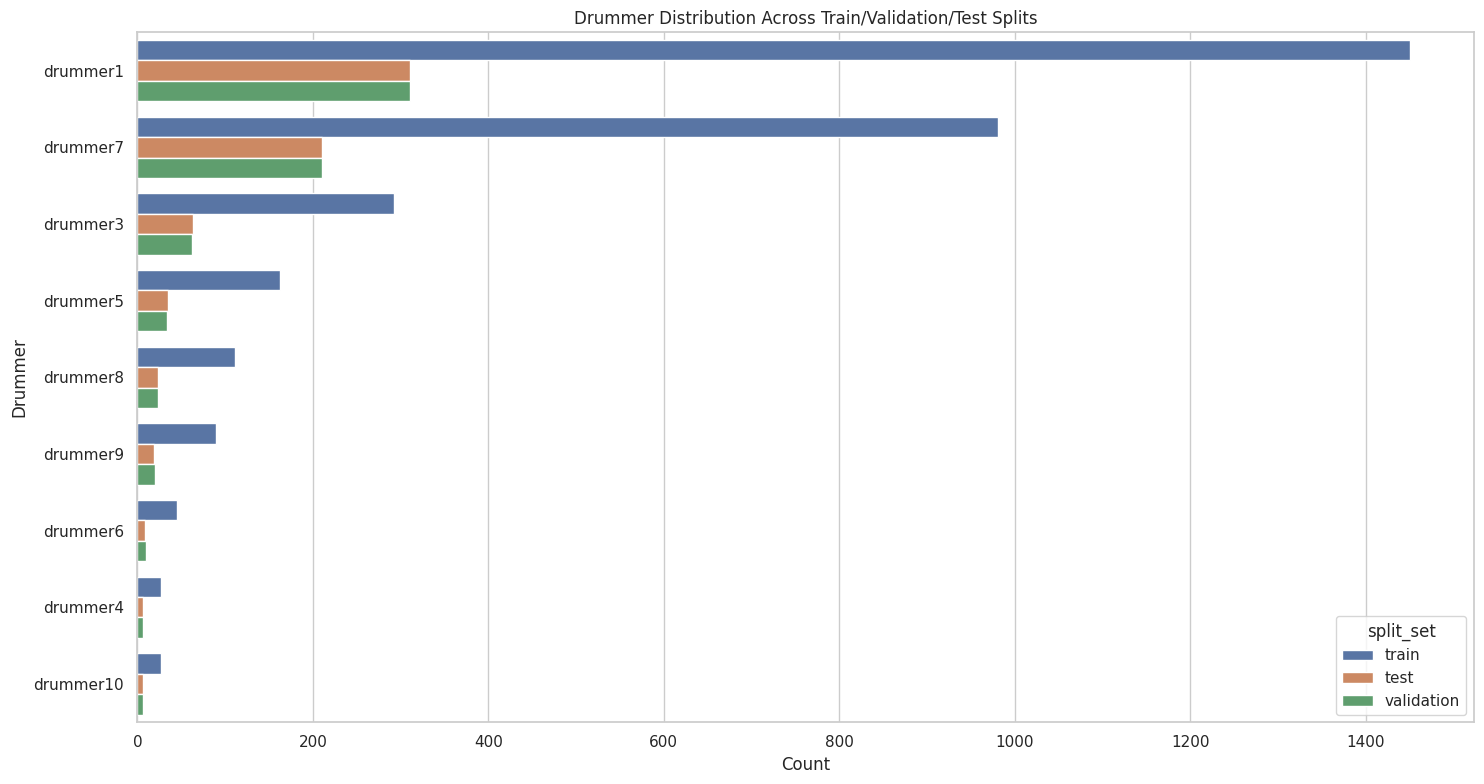


Split proportions are within tolerance.

Visually inspect the table and plot above to confirm drummer distribution is similar across splits.


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

if not df_subset.empty and "split_set" in df_subset.columns:
    print("--- Split Set Value Counts ---")
    split_counts = df_subset["split_set"].value_counts(normalize=True) * 100
    print(split_counts)

    print("\n--- Drummer Distribution per Split Set ---")
    # Calculate drummer distribution within each split
    drummer_dist = (
        df_subset.groupby("split_set")["drummer"]
        .value_counts(normalize=True)
        .unstack(level=0)
        * 100
    )

    # Display the distribution table
    display(
        drummer_dist.style.format("{:.2f}%").background_gradient(cmap="viridis", axis=1)
    )

    # Optional: Visualize the distribution
    plt.figure(figsize=(15, 8))
    sns.countplot(
        data=df_subset,
        y="drummer",
        hue="split_set",
        order=df_subset["drummer"].value_counts().index,
    )
    plt.title("Drummer Distribution Across Train/Validation/Test Splits")
    plt.xlabel("Count")
    plt.ylabel("Drummer")
    plt.tight_layout()
    plt.show()

    # Check if proportions are roughly correct
    target_proportions = {"train": 70.0, "validation": 15.0, "test": 15.0}
    all_proportions_ok = True
    for split_name, target_prop in target_proportions.items():
        actual_prop = split_counts.get(split_name, 0)
        if not np.isclose(actual_prop, target_prop, atol=2.0):  # Allow 2% tolerance
            print(
                f"Warning: Proportion for '{split_name}' ({actual_prop:.2f}%) is off target ({target_prop:.1f}%)."
            )
            all_proportions_ok = False

    if all_proportions_ok:
        print("\nSplit proportions are within tolerance.")

    # Check stratification (visual inspection or more rigorous statistical tests could be added)
    print(
        "\nVisually inspect the table and plot above to confirm drummer distribution is similar across splits."
    )

else:
    print(
        "Subset DataFrame is empty or 'split_set' column not found. Skipping verification."
    )

### 6.5. Save Updated Subset Metadata

Finally, save the `df_subset` DataFrame, now including the `split_set` column, back to the CSV file, overwriting the previous version.

In [25]:
if not df_subset.empty and "split_set" in df_subset.columns:
    print(f"Saving updated subset metadata to: {SUBSET_METADATA_PATH.resolve()}")
    try:
        df_subset.to_csv(SUBSET_METADATA_PATH, index=False)
        print("Updated subset metadata saved successfully.")
    except Exception as e:
        print(f"Error saving updated subset metadata: {e}")
else:
    print(
        "Subset DataFrame is empty or 'split_set' column missing. Skipping metadata saving."
    )

Saving updated subset metadata to: /home/ivan/uni/APPSA/DrumScribe-AI/data/subset/subset_metadata.csv
Updated subset metadata saved successfully.


## 7. Visualize Subset Examples

Let's visualize a couple of random examples from our subset to get a feel for the audio and corresponding MIDI drum patterns.

In [26]:
SUBSET_METADATA_PATH: Path = Path("../data/subset/subset_metadata.csv")
SUBSET_DATA_DIR: Path = Path("../data/subset/")

if "df_subset" not in locals() or df_subset.empty:
    if SUBSET_METADATA_PATH.exists():
        print(f"Reloading subset metadata from: {SUBSET_METADATA_PATH.resolve()}")
        try:
            df_subset: pd.DataFrame = pd.read_csv(SUBSET_METADATA_PATH)
            print("Subset metadata reloaded successfully.")
        except Exception as e:
            print(f"Error reloading subset metadata: {e}")
            df_subset = pd.DataFrame()  # Assign empty df on error
    else:
        print(
            f"Error: Subset metadata file not found at {SUBSET_METADATA_PATH.resolve()}"
        )
        df_subset = pd.DataFrame()


def plot_drum_piano_roll(
    pm: pretty_midi.PrettyMIDI,
    start_pitch: int = 35,
    end_pitch: int = 52,
    fs: int = 100,
):
    """
    Plots a piano roll representation for simplified drum notes with distinct colors.

    Args:
        pm (pretty_midi.PrettyMIDI): The PrettyMIDI object
        start_pitch (int): The lowest MIDI pitch to include (default: 35)
        end_pitch (int): The highest MIDI pitch to include (default: 52)
        fs (int): Sampling frequency for the piano roll grid
    """
    # Define colors for each drum type
    drum_colors = {
        36: 'red',      # Kick
        38: 'blue',     # Snare
        42: 'green',    # HiHat
        47: 'purple',   # Tom
        49: 'orange',   # Crash
        51: 'yellow',   # Ride
    }

    # Find the drum instrument
    drum_instrument = None
    for instrument in pm.instruments:
        if instrument.is_drum:
            drum_instrument = instrument
            break

    if drum_instrument is None or len(drum_instrument.notes) == 0:
        print("No drum track found or the drum track has no notes.")
        duration = pm.get_end_time()
        plt.gca().set_xlim([0, duration])
        plt.gca().set_ylim([start_pitch, end_pitch])
        plt.title("Drum Piano Roll (No notes found)")
        return

    # Print notes found
    pitch_counts = {}
    for note in drum_instrument.notes:
        if start_pitch <= note.pitch <= end_pitch:
            if note.pitch not in pitch_counts:
                pitch_counts[note.pitch] = 0
            pitch_counts[note.pitch] += 1

    if pitch_counts:
        print("Detected drum hits:")
        for pitch, count in sorted(pitch_counts.items()):
            drum_name = get_drum_name_simplified(pitch)
            print(f"  {drum_name} (pitch {pitch}): {count} hits")

    # Create a clean figure with proper time axis
    duration = pm.get_end_time()
    plt.gca().set_xlim([0, duration])
    plt.gca().set_ylim([start_pitch - 0.5, end_pitch + 0.5])

    # Plot each note as a colored line for its duration
    for note in drum_instrument.notes:
        if start_pitch <= note.pitch <= end_pitch:
            # Map to simplified pitch
            simplified_pitch, _ = get_roland_to_simplified_category(note.pitch)

            # Get color (default to gray for unknown pitches)
            color = drum_colors.get(simplified_pitch, 'gray')

            # Plot horizontal line for note duration
            plt.hlines(
                y=simplified_pitch,
                xmin=note.start,
                xmax=note.end,
                colors=color,
                linewidth=4
            )

    # Set ticks and labels for simplified drum mapping
    simplified_drums = {
        36: "Kick",
        38: "Snare",
        42: "HiHat",
        47: "Tom",
        49: "Crash",
        51: "Ride"
    }

    # Create ticks at these pitches
    plt.yticks(list(simplified_drums.keys()))

    # Add drum names as text labels
    for pitch, name in simplified_drums.items():
        if start_pitch <= pitch <= end_pitch:
            plt.text(-0.5, pitch, name, ha="right", va="center")

    # Create a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=drum_colors[pitch], lw=4, label=name)
        for pitch, name in simplified_drums.items()
        if pitch in drum_colors
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.ylabel("Drum Type")
    plt.xlabel("Time (s)")
    plt.title("Drum Piano Roll (Simplified Mapping)")
    plt.grid(True, alpha=0.3)

In [ ]:
import subprocess
import tempfile
from IPython.display import HTML
from IPython.display import Audio
import librosa
import librosa.display
import pretty_midi
from pathlib import Path

# Define paths
SOUNDFONT_PATH = Path("../soundfont/FluidR3_GM.sf2")

def midi_to_audio(midi_path, soundfont_path, output_wav_path, sr=22050):
    """Turn a MIDI file into WAV audio using FluidSynth."""
    midi_path = Path(midi_path)
    soundfont_path = Path(soundfont_path)
    output_wav_path = Path(output_wav_path)

    if not soundfont_path.exists():
        return False  # Need soundfont
    if not midi_path.exists():
        return False  # Need the midi file

    try:
        command = ['fluidsynth', '-ni', str(soundfont_path), str(midi_path),
                   '-F', str(output_wav_path), '-r', str(sr)]
        subprocess.run(command, check=True, capture_output=True,
                      text=True, timeout=30)  # Run command
        return True  # Success!
    except Exception as e:
        print(f"  -> FluidSynth failed: {e}")  # Print error if synth fails
        return False  # Failed

def play_audio_and_midi(audio_path, pm, sr=44100):
    """
    Provides playback for both the original audio and synthesized MIDI using FluidSynth.
    """
    # Load the audio file
    y, _ = librosa.load(audio_path, sr=sr)

    # Create temporary directory to store midi and wav files
    with tempfile.TemporaryDirectory() as tmpdir:
        temp_dir_path = Path(tmpdir)

        # Create temporary file paths
        temp_midi_path = temp_dir_path / "temp_drum.mid"
        temp_wav_path = temp_dir_path / "temp_drum.wav"

        # Save the MIDI
        pm.write(str(temp_midi_path))

        # Check if we can synthesize
        can_synthesize = SOUNDFONT_PATH.exists()

        print("Original Audio Recording:")
        display(Audio(data=y, rate=sr))

        # Synthesize MIDI with FluidSynth
        if can_synthesize:
            print("\nSynthesizing MIDI with FluidSynth...")
            if midi_to_audio(temp_midi_path, SOUNDFONT_PATH, temp_wav_path, sr=sr):
                try:
                    # Load and play the synthesized audio
                    midi_audio, sr_midi = librosa.load(temp_wav_path, sr=sr)
                    print("\nSynthesized MIDI Drum Pattern:")
                    display(Audio(data=midi_audio, rate=sr_midi))
                except Exception as e:
                    print(f"Error loading synthesized audio: {e}")
            else:
                print("Failed to synthesize MIDI. Make sure FluidSynth is installed.")
        else:
            print(f"\nCannot synthesize MIDI: SoundFont not found at {SOUNDFONT_PATH}")
            print("Download a SoundFont file and update the SOUNDFONT_PATH variable.")


--- Visualizing Example 247 ---
Drummer: drummer1, Style: reggae, Tempo: 78.00 BPM, Split: train
Audio Path: ../data/subset/train/drummer1/session1/197_reggae_78_fill_4-4_19.wav
MIDI Path: ../data/subset/train/drummer1/session1/197_reggae_78_fill_4-4_19.midi
Audio loaded: duration=3.08s, sample_rate=44100Hz
MIDI loaded: estimated tempo=164.45 BPM
Detected drum hits:
  Kick (pitch 36): 2 hits
  Snare (pitch 38): 3 hits
  HiHat (pitch 42): 3 hits
  Tom (pitch 47): 1 hits
  Ride (pitch 51): 1 hits

--- Audio and MIDI Playback ---
Original Audio Recording:



Synthesizing MIDI with FluidSynth...

Synthesized MIDI Drum Pattern:


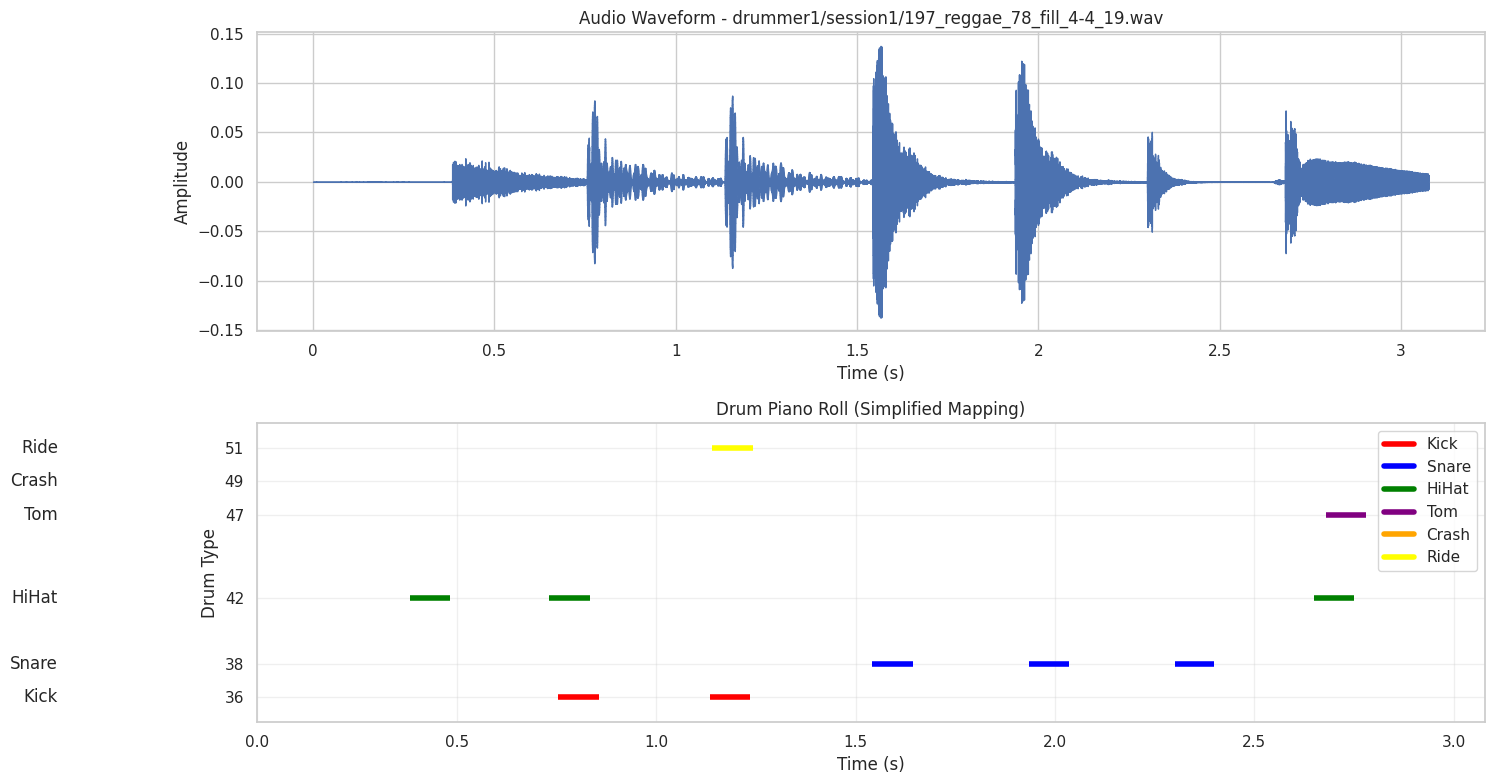


--- Visualizing Example 3642 ---
Drummer: drummer7, Style: pop, Tempo: 142.00 BPM, Split: validation
Audio Path: ../data/subset/train/drummer7/session2/98_pop_142_fill_4-4_6.wav
MIDI Path: ../data/subset/train/drummer7/session2/98_pop_142_fill_4-4_6.midi
Audio loaded: duration=5.88s, sample_rate=44100Hz
MIDI loaded: estimated tempo=204.75 BPM
Detected drum hits:
  Kick (pitch 36): 6 hits
  Snare (pitch 38): 13 hits
  Tom (pitch 47): 13 hits

--- Audio and MIDI Playback ---
Original Audio Recording:



Synthesizing MIDI with FluidSynth...

Synthesized MIDI Drum Pattern:


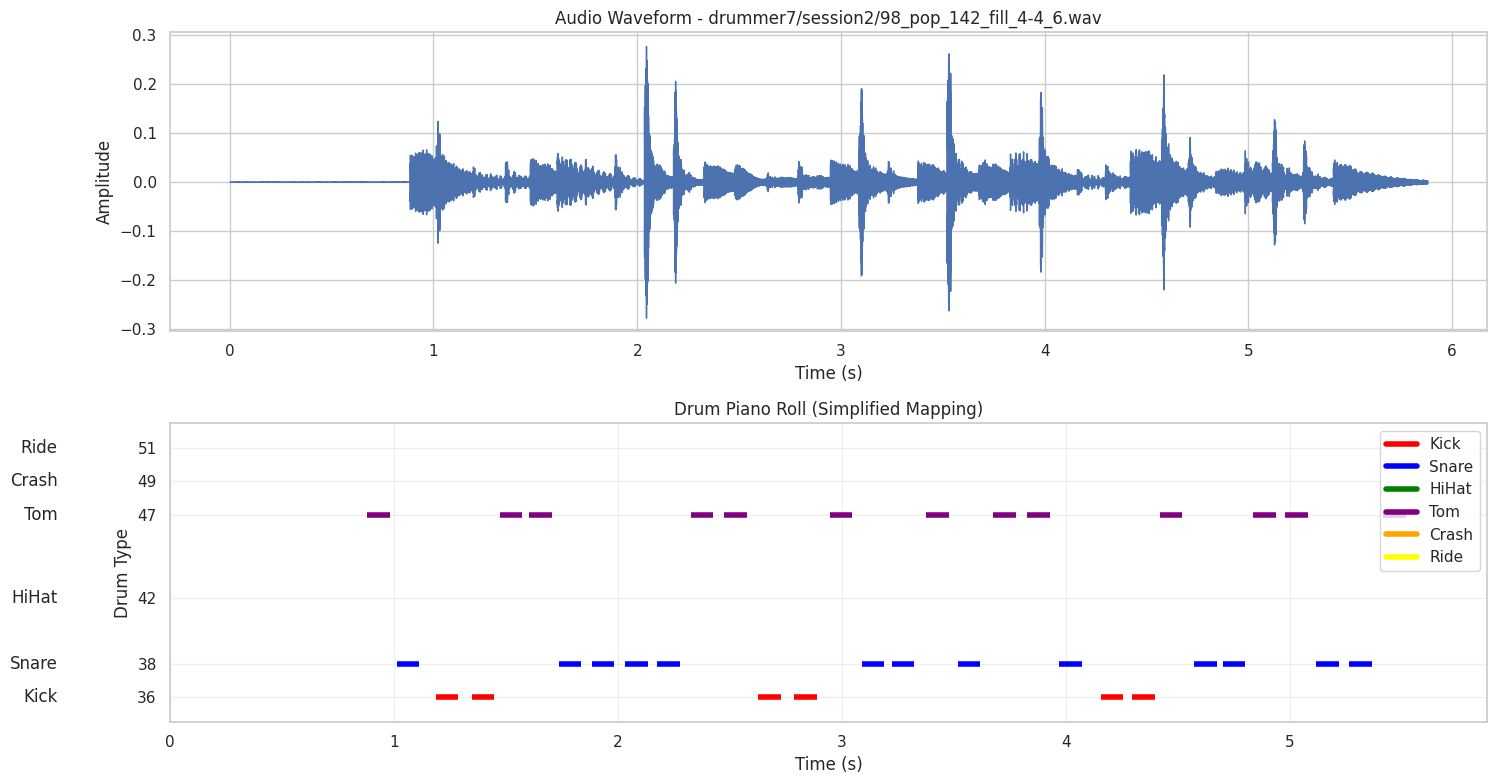

In [ ]:


if not df_subset.empty:
    # Select 2 random examples
    num_examples_to_show = 2
    random_indices = random.sample(range(len(df_subset)), num_examples_to_show)
    example_rows = df_subset.iloc[random_indices]

    for index, row in example_rows.iterrows():
        print(f"\n--- Visualizing Example {index} ---")
        # Use 'bpm' column for tempo display
        print(
            f"Drummer: {row['drummer']}, Style: {row['style']}, Tempo: {row['bpm']:.2f} BPM, Split: {row['split_set']}"
        )

        # Construct file paths
        # Path structure: SUBSET_DATA_DIR / split / audio_filename (which includes drummer/session/etc)
        audio_path: Path = SUBSET_DATA_DIR / \
            row["split"] / row["audio_filename"]
        midi_path: Path = SUBSET_DATA_DIR / row["split"] / row["midi_filename"]

        print(f"Audio Path: {audio_path}")
        print(f"MIDI Path: {midi_path}")

        try:
            # Load audio
            # Load with original sample rate
            y, sr = librosa.load(audio_path, sr=None)
            print(
                f"Audio loaded: duration={librosa.get_duration(y=y, sr=sr):.2f}s, sample_rate={sr}Hz"
            )

            # Load MIDI
            pm = pretty_midi.PrettyMIDI(str(midi_path))
            print(
                f"MIDI loaded: estimated tempo={pm.estimate_tempo():.2f} BPM")

            # Create plots
            plt.figure(figsize=(15, 8))

            # Plot 1: Waveform
            plt.subplot(2, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title(f"Audio Waveform - {row['audio_filename']}")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")

            # Plot 2: Drum Piano Roll
            plt.subplot(2, 1, 2)
            plot_drum_piano_roll(
                pm, fs=sr
            )  # Use audio sample rate for fs in piano roll for alignment
            # Adjust x-axis limits to match waveform
            plt.xlim([0, librosa.get_duration(y=y, sr=sr)])
            plt.xlabel("Time (s)")

            print("\n--- Audio and MIDI Playback ---")
            play_audio_and_midi(audio_path, pm, sr=sr)

            plt.tight_layout()
            plt.show()

        except FileNotFoundError:
            print(
                f"Error: Audio or MIDI file not found for index {index}. Skipping visualization."
            )
            print(f"  Expected Audio: {audio_path}")
            print(f"  Expected MIDI: {midi_path}")
        except Exception as e:
            print(f"An error occurred processing index {index}: {e}")

else:
    print("Subset DataFrame is empty. Cannot visualize examples.")

## 8. Generate Subset Statistics

Finally, let's calculate and display some key statistics about our created subset to provide a final overview.

In [31]:
if not df_subset.empty:
    print("--- Subset Statistics ---")

    # Total number of files
    total_files = len(df_subset)
    print(f"Total number of files (audio/MIDI pairs): {total_files}")

    # Total duration
    if "duration" in df_subset.columns:
        total_duration_seconds = df_subset["duration"].sum()
        total_duration_hours = total_duration_seconds / 3600
        print(
            f"Total duration of audio: {total_duration_seconds:.2f} seconds (~{total_duration_hours:.2f} hours)"
        )
    else:
        print(
            "Warning: 'duration' column not found in metadata. Cannot calculate total duration."
        )

else:
    print("Subset DataFrame is empty. Cannot generate statistics.")

--- Subset Statistics ---
Total number of files (audio/MIDI pairs): 4554
Total duration of audio: 160899.97 seconds (~44.69 hours)


### 8.1. Subset Distributions

Re-displaying the distributions for key features specifically for the subset.


--- Subset Categorical Distributions ---


/tmp/ipykernel_302268/2162821425.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


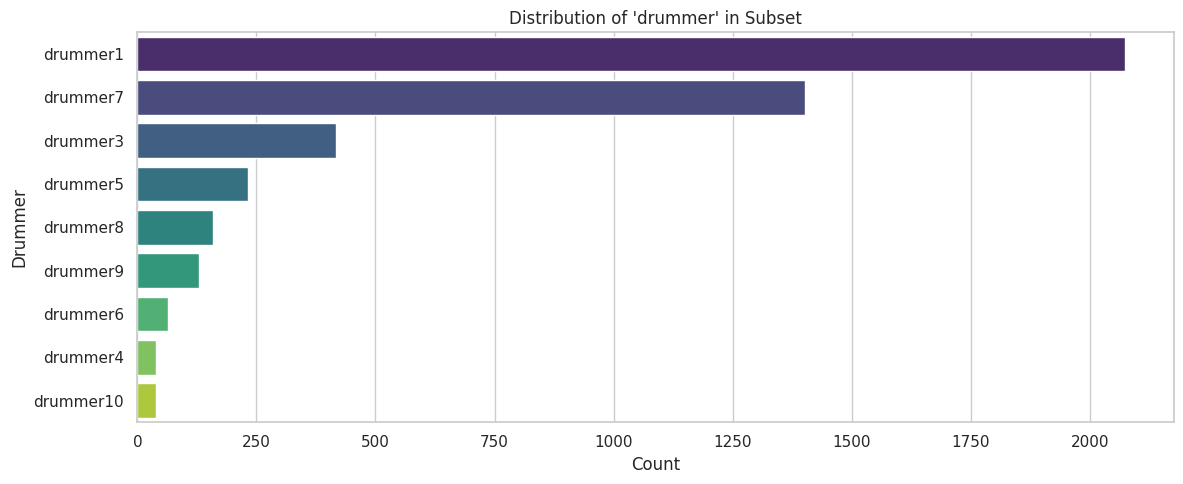

/tmp/ipykernel_302268/2162821425.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


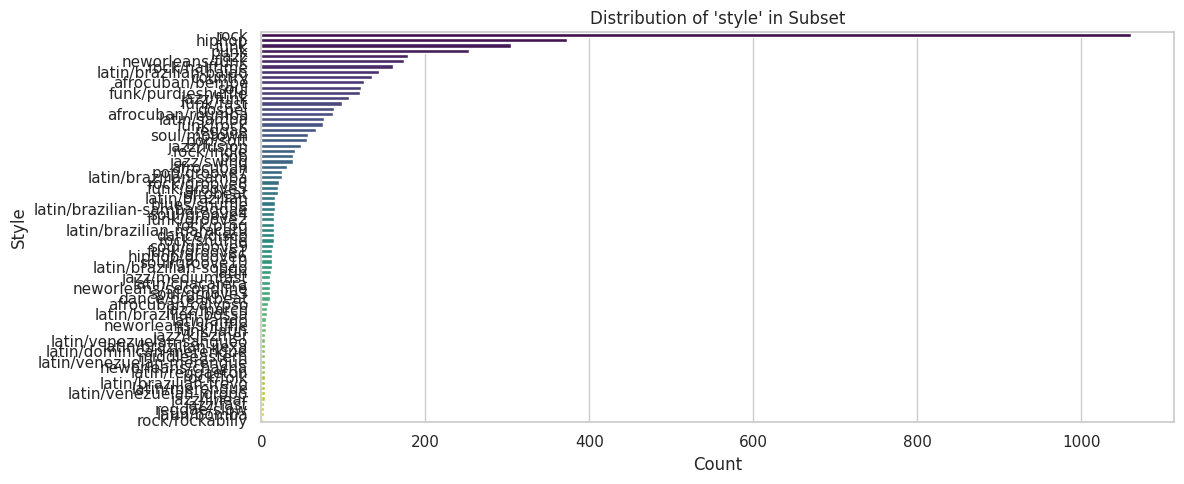

/tmp/ipykernel_302268/2162821425.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


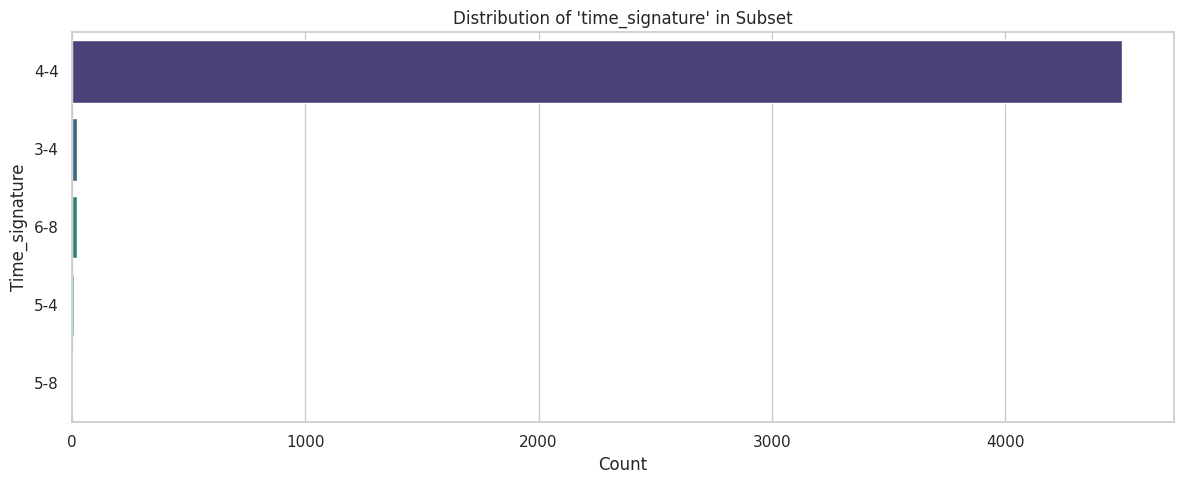

/tmp/ipykernel_302268/2162821425.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


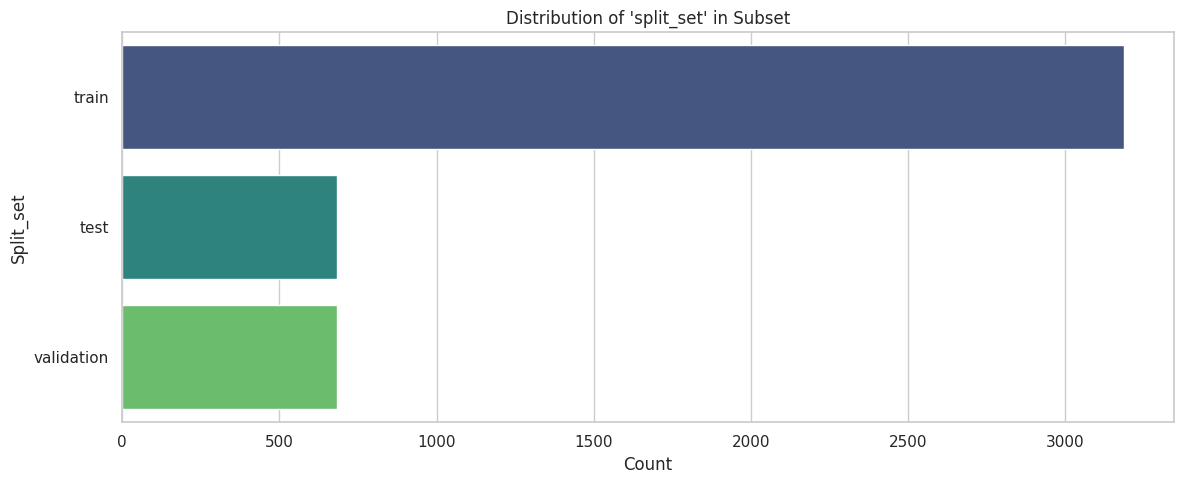


--- Subset Numerical Distributions ---


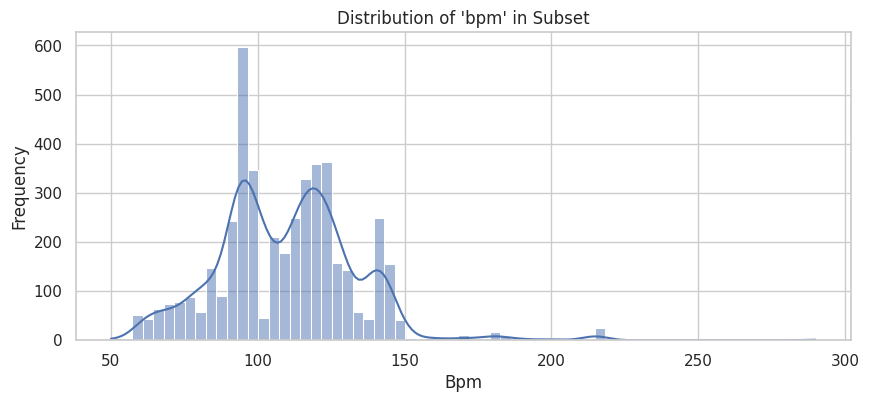

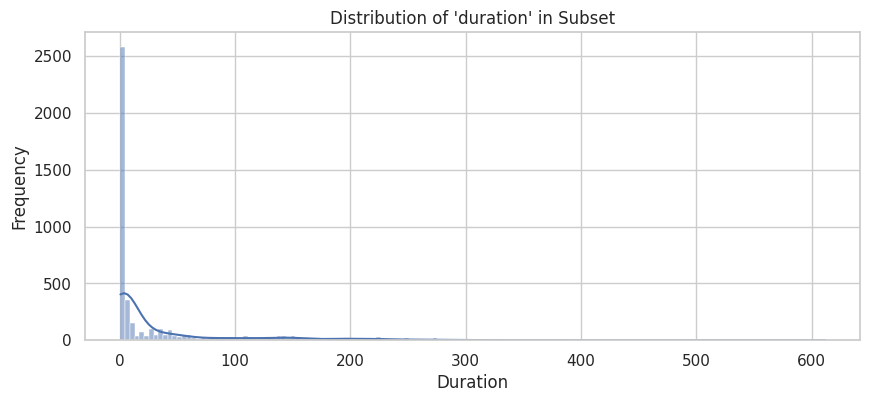

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

if not df_subset.empty:
    # Columns to visualize
    categorical_cols_subset: typing.List[str] = [
        "drummer",
        "style",
        "time_signature",
        "split_set",
    ]
    # Use 'bpm' column for tempo visualization
    numerical_cols_subset: typing.List[str] = ["bpm", "duration"]

    print("\n--- Subset Categorical Distributions ---")
    for col in categorical_cols_subset:
        if col in df_subset.columns:
            plt.figure(figsize=(12, 5))
            sns.countplot(
                data=df_subset,
                y=col,
                order=df_subset[col].value_counts().index,
                palette="viridis",
            )
            plt.title(f"Distribution of '{col}' in Subset")
            plt.xlabel("Count")
            plt.ylabel(col.capitalize())
            plt.tight_layout()
            plt.show()
        else:
            print(f"Column '{col}' not found in subset metadata.")

    print("\n--- Subset Numerical Distributions ---")
    for col in numerical_cols_subset:
        if col in df_subset.columns:
            plt.figure(figsize=(10, 4))
            sns.histplot(df_subset[col], kde=True)
            plt.title(f"Distribution of '{col}' in Subset")
            plt.xlabel(col.capitalize())
            plt.ylabel("Frequency")
            plt.show()
        else:
            print(f"Column '{col}' not found for visualization.")

else:
    print("Subset DataFrame is empty, skipping distribution visualizations.")

**End of Notebook 1.**

We have successfully explored the E-GMD dataset, created a stratified 10% subset, copied the relevant files, split the subset into train/validation/test sets, visualized some examples, and generated final statistics. The subset metadata is saved in `data/subset/subset_metadata.csv`.